In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

%matplotlib inline

In [4]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [5]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Данные

## Выбрать временный ряд

   (данные внутреннего датчика температуры оборудования из датасета NAB)


In [6]:
nab = pd.read_csv('machine_temperature_system_failure.csv', index_col=['timestamp'], parse_dates=['timestamp'])

In [7]:
# Removing duplicate timestamps in the index by keeping the first occurrence
nab = nab[~nab.index.duplicated(keep='first')]

# Re-run the frequency setting and confirm if data is correctly formatted for SARIMA model
nab = nab.asfreq('5T')

In [8]:
nab_resampled = nab.resample('5T').ffill()

In [9]:
nab.head(), nab.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22683 entries, 2013-12-02 21:15:00 to 2014-02-19 15:25:00
Freq: 5min
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   22683 non-null  float64
dtypes: float64(1)
memory usage: 354.4 KB


(                         value
 timestamp                     
 2013-12-02 21:15:00  73.967322
 2013-12-02 21:20:00  74.935882
 2013-12-02 21:25:00  76.124162
 2013-12-02 21:30:00  78.140707
 2013-12-02 21:35:00  79.329836,
 None)

## Визуализировать ряд и на основе его внешнего вида сделайте предположения о его компонентах (тренд, сезонность) и стационарности

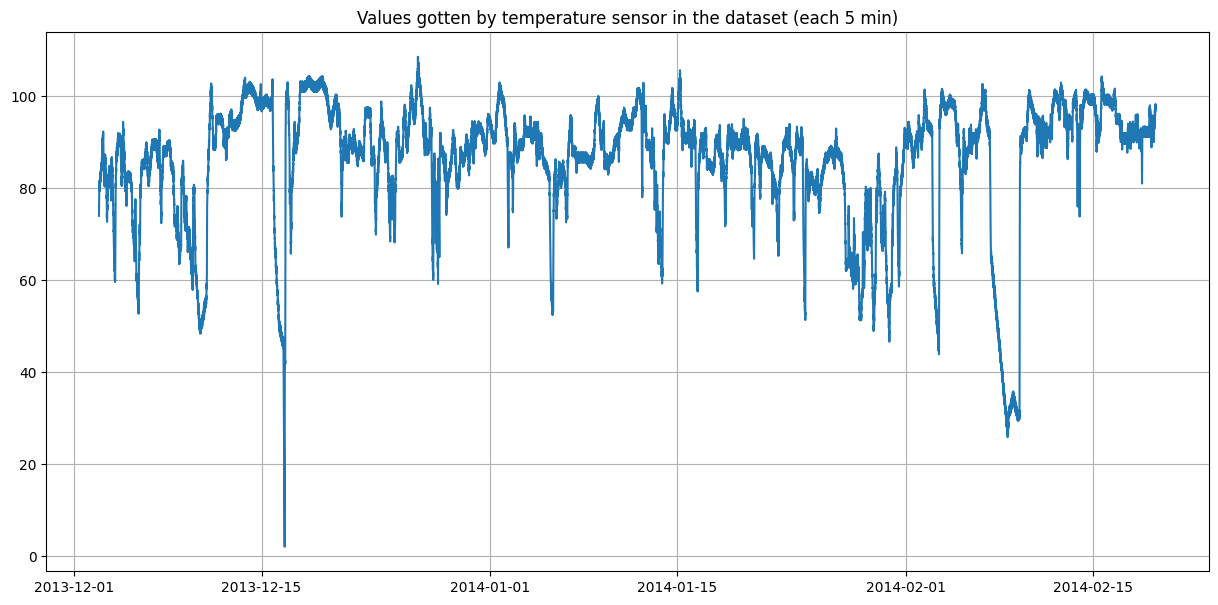

In [10]:
plt.figure(figsize=(15, 7))
plt.plot(nab.value)
plt.title('Values gotten by temperature sensor in the dataset (each 5 min)')
plt.grid(True)
plt.show()

Тренд: На графике видно, что сначала температура постепенно растет. Это говорит о том, что у временного ряда есть восходящий тренд — т.е., общая тенденция к увеличению значений со временем.

Сезонность: График не показывает четких повторяющихся колебаний, которые можно было бы назвать сезонностью. Хотя небольшие колебания есть, они не имеют регулярного, предсказуемого характера.

Стационарность: Временной ряд, вероятно, не является стационарным, так как средний уровень температуры меняется со временем. Обычно для стационарного ряда характерно постоянство среднего значения и разброса (дисперсии), а здесь наблюдается их изменение.

# Бейзлайн

## Построить бейзлайн в виде наивного прогноза или скользящего среднего

In [11]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(nab, 12) #prediction for the last hour

97.42734236999998

In [12]:
moving_average(nab, 288) #prediction for the last day

93.05078513836806

## Визуализиовать результаты работы модели, произведите замеры качества с выбранной метрикой

In [13]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,7))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        print(f'MAE: {mae}')
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=7)
    #plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

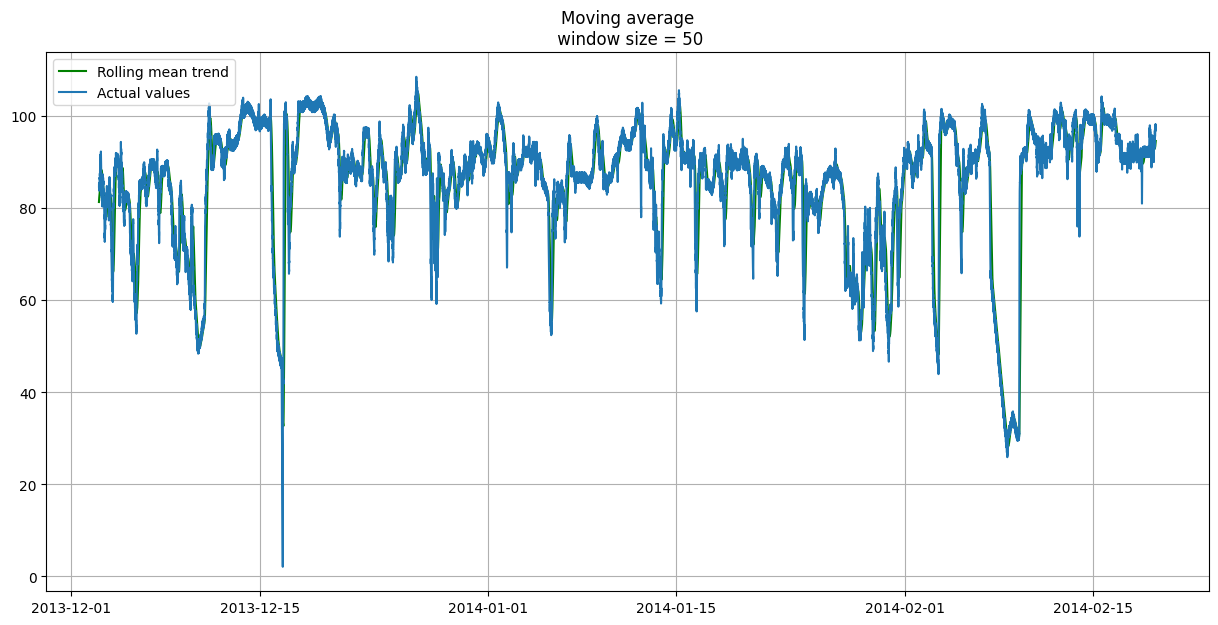

In [14]:
plotMovingAverage(nab, 50) #moving 4 hours

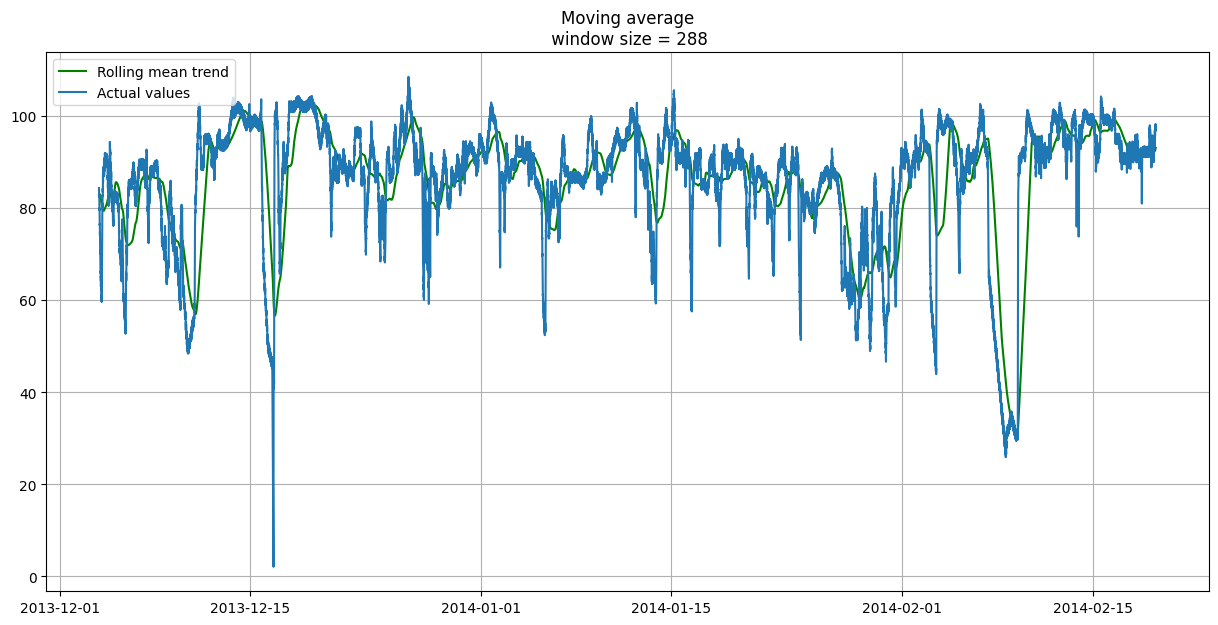

In [15]:
plotMovingAverage(nab, 288)    #moving 1 day

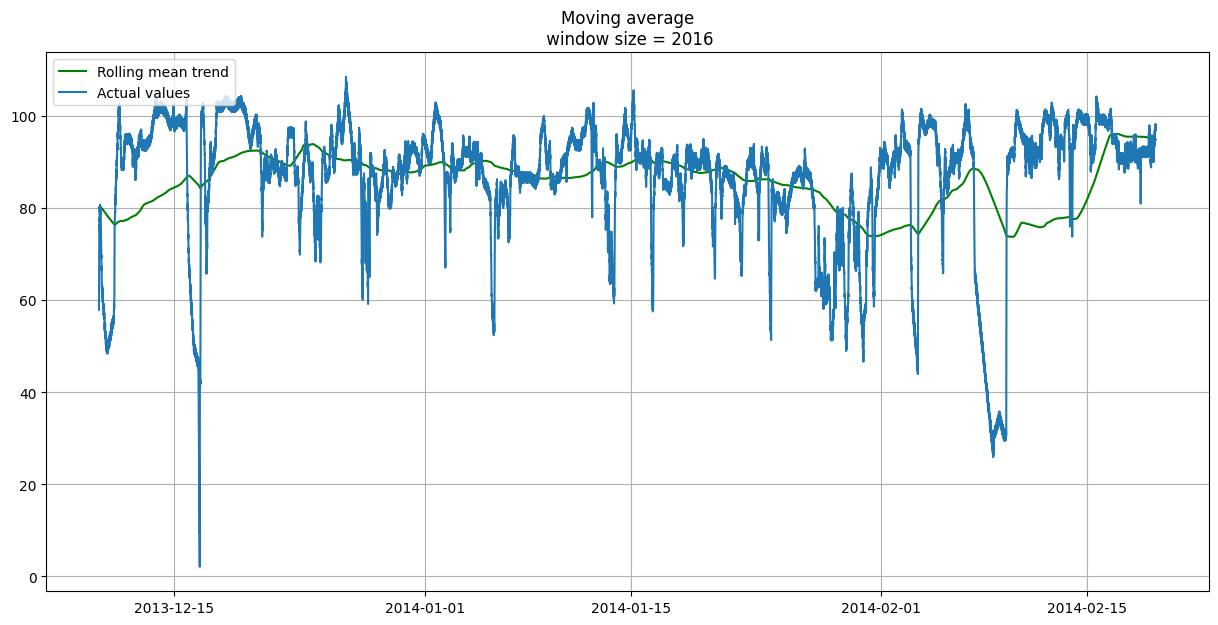

In [16]:
plotMovingAverage(nab, 288*7)    #moving 1 week

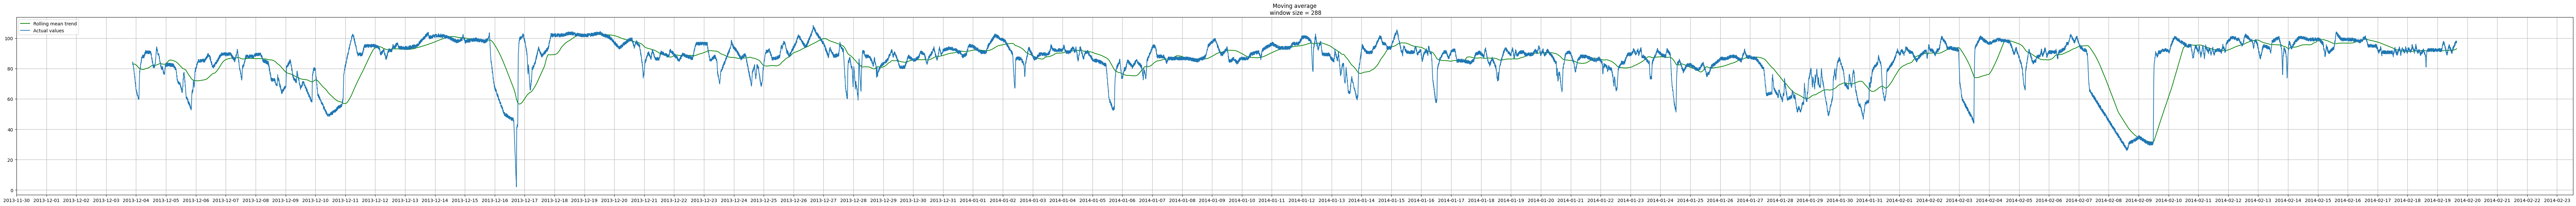

In [17]:
series=nab
window=288
scale=1.96
plot_intervals=False
plot_anomalies = False
rolling_mean = series.rolling(window).mean()

plt.figure(figsize=(100,7))
plt.title("Moving average\n window size = {}".format(window))
plt.plot(rolling_mean, "g", label="Rolling mean trend")

# Plot confidence intervals for smoothed values
if plot_intervals:
    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    print(f'MAE: {mae}')
    deviation = np.std(series[window:] - rolling_mean[window:])
    lower_bond = rolling_mean - (mae + scale * deviation)
    upper_bond = rolling_mean + (mae + scale * deviation)
    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")

    # Having the intervals, find abnormal values
    if plot_anomalies:
        anomalies = pd.DataFrame(index=series.index, columns=series.columns)
        anomalies[series<lower_bond] = series[series<lower_bond]
        anomalies[series>upper_bond] = series[series>upper_bond]
        plt.plot(anomalies, "ro", markersize=7)

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.plot(series[window:], label="Actual values")
plt.legend(loc="upper left")
plt.grid(True)

MAE: 2.9431909773581495


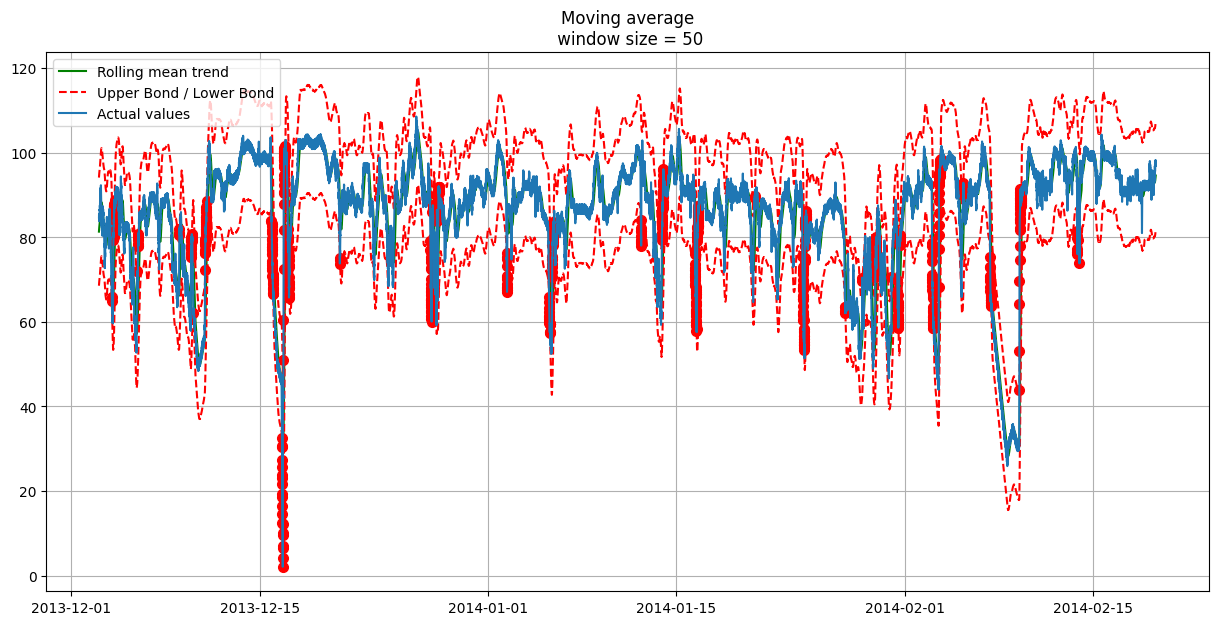

In [18]:
plotMovingAverage(nab, 50, plot_intervals=True, plot_anomalies=True)

Бейзлайн, построенный с использованием скользящего среднего с окном 50, имеет метрику качества (MAE) примерно 2.94. Это значение показывает среднюю величину абсолютной ошибки между фактическими значениями и сглаженными, что помогает оценить, насколько хорошо скользящее среднее отражает основную тенденцию в данных.

MAE: 6.470642489210356


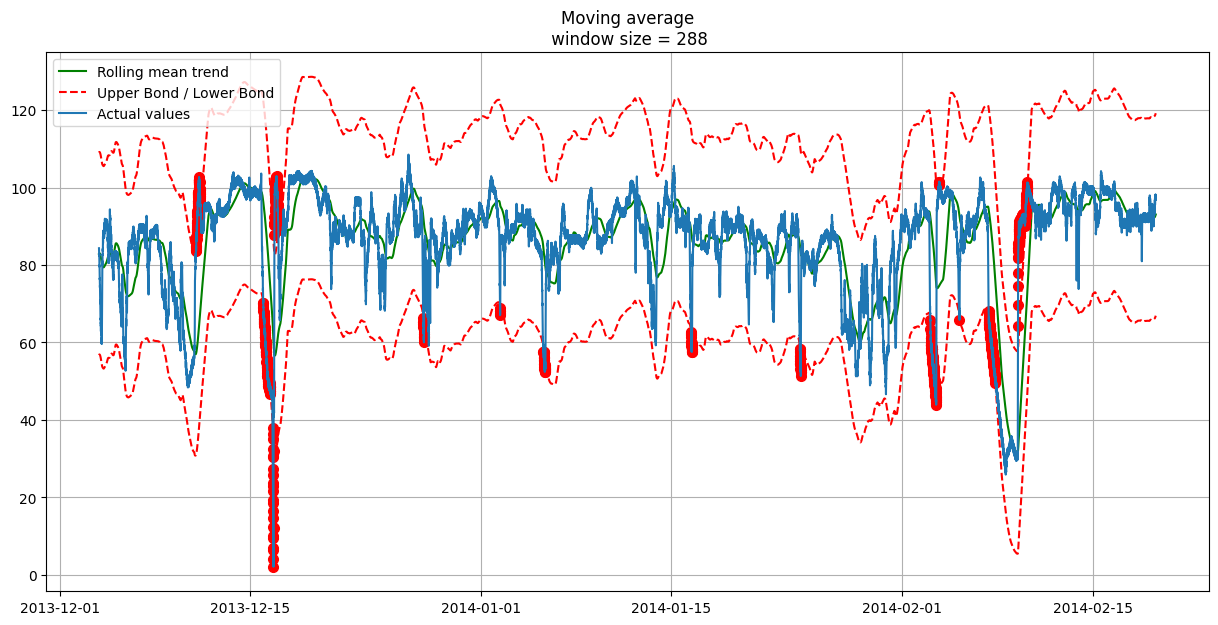

In [19]:
plotMovingAverage(nab, 288, plot_intervals=True, plot_anomalies=True)

MAE: 5.793028001134144


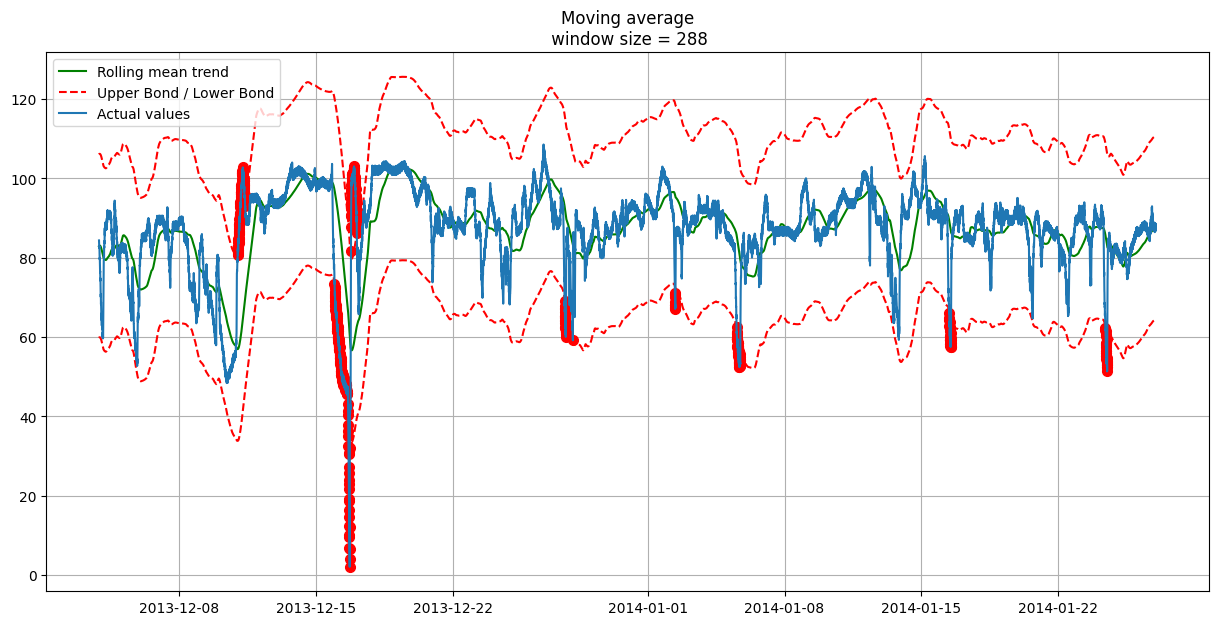

In [20]:
ini_len_nab=int(len(nab)*0)
end_len_nab=int(len(nab)*0.7)
plotMovingAverage(nab[ini_len_nab:end_len_nab], 288, plot_intervals=True, plot_anomalies=True)

# Статистическая модель

## Проведите тест Дики-Фуллера и интерпретируйте результаты

In [21]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [22]:
weighted_average(nab, [0.6, 0.3, 0.1])

97.272918981

In [23]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [24]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters

    """
    with plt.style.context('seaborn-v0_8-whitegrid'):
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

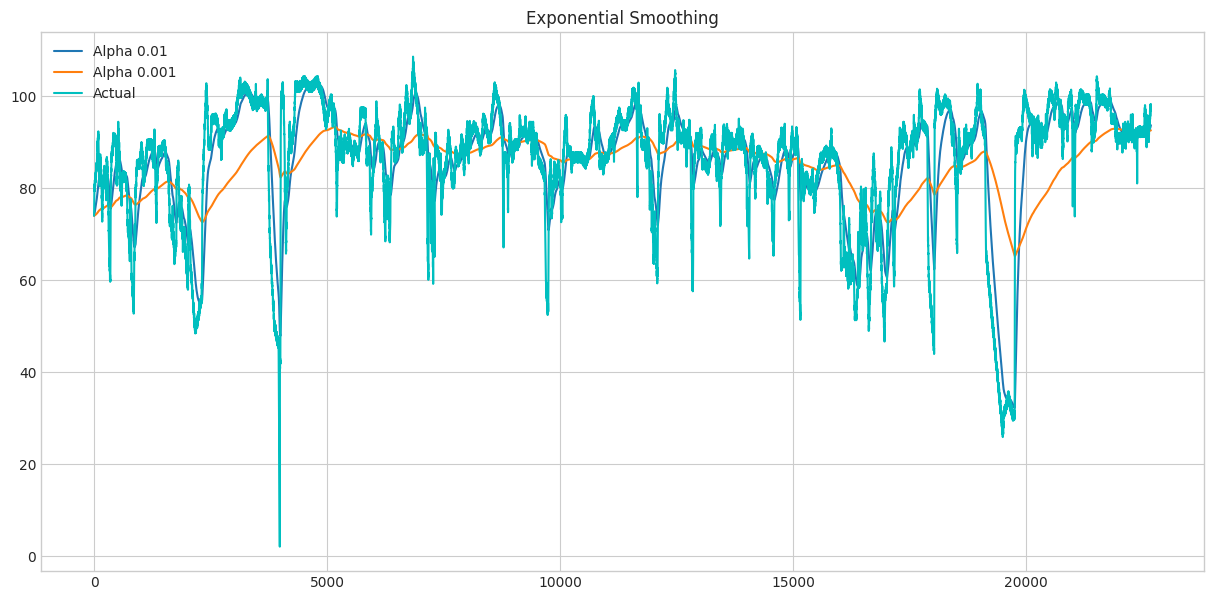

In [25]:
plotExponentialSmoothing(nab.value, [0.01, 0.001])

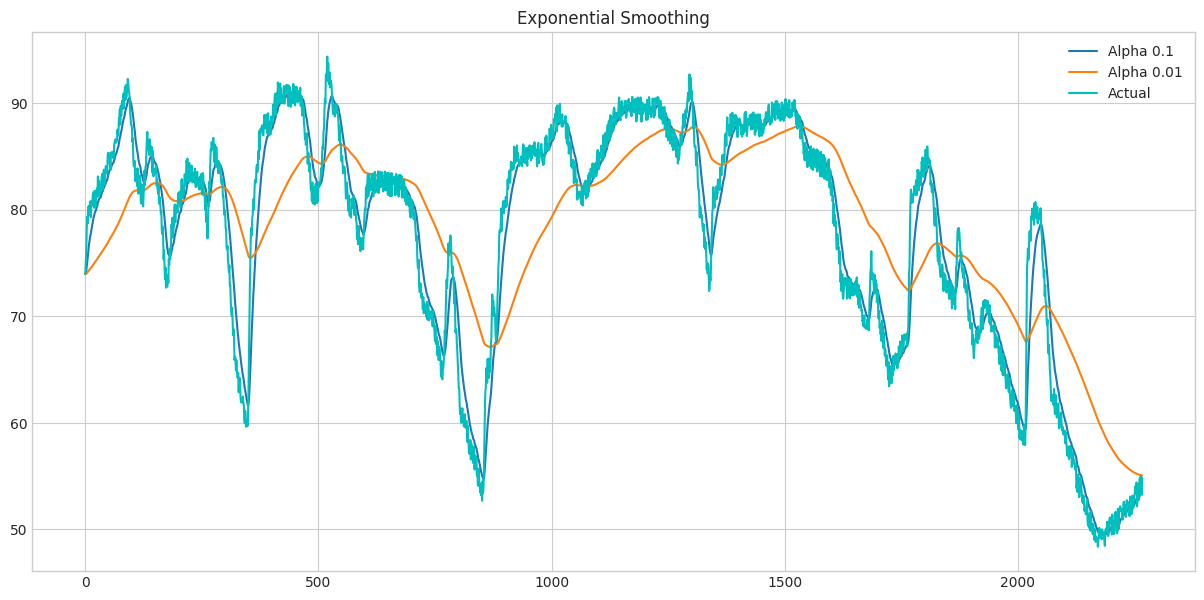

In [26]:
ini_len_nab=int(len(nab)*0)
end_len_nab=int(len(nab)*0.1)
plotExponentialSmoothing(nab[ini_len_nab:end_len_nab].value, [0.1, 0.01])

In [27]:
print("Serie temporal original\nDickey-Fuller p-value: {}".format(sm.tsa.adfuller(nab.value)[1], 3))

Serie temporal original
Dickey-Fuller p-value: 9.188330601193452e-11


P-значение: 9.07×10^-11, что значительно ниже стандартного уровня значимости 0.05,

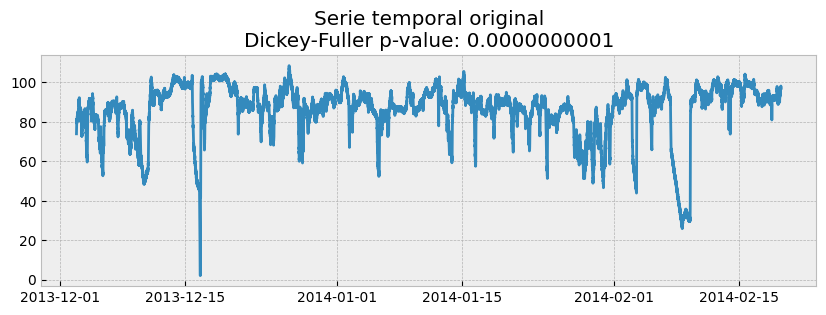

In [28]:
def plotProcess_from_data(data):
    n_samples = len(data)

    with plt.style.context('bmh'):
        plt.figure(figsize=(10, 3))
        plt.plot(data)
        plt.title("Serie temporal original\nDickey-Fuller p-value: {0:.10f}".format(sm.tsa.adfuller(data)[1], 3))
    plt.show()

# Llama a la función con los datos originales de la columna deseada
# ini_len_nab=int(len(nab)*0)
# end_len_nab=int(len(nab)*1)
plotProcess_from_data(nab.value)

With this result, we can conclude that the series is stationary.

In [29]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.10f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

## Постройте графики ACF/PACF и проанализируйте их, сделайте предположения о наличии/отсутствии сезонности

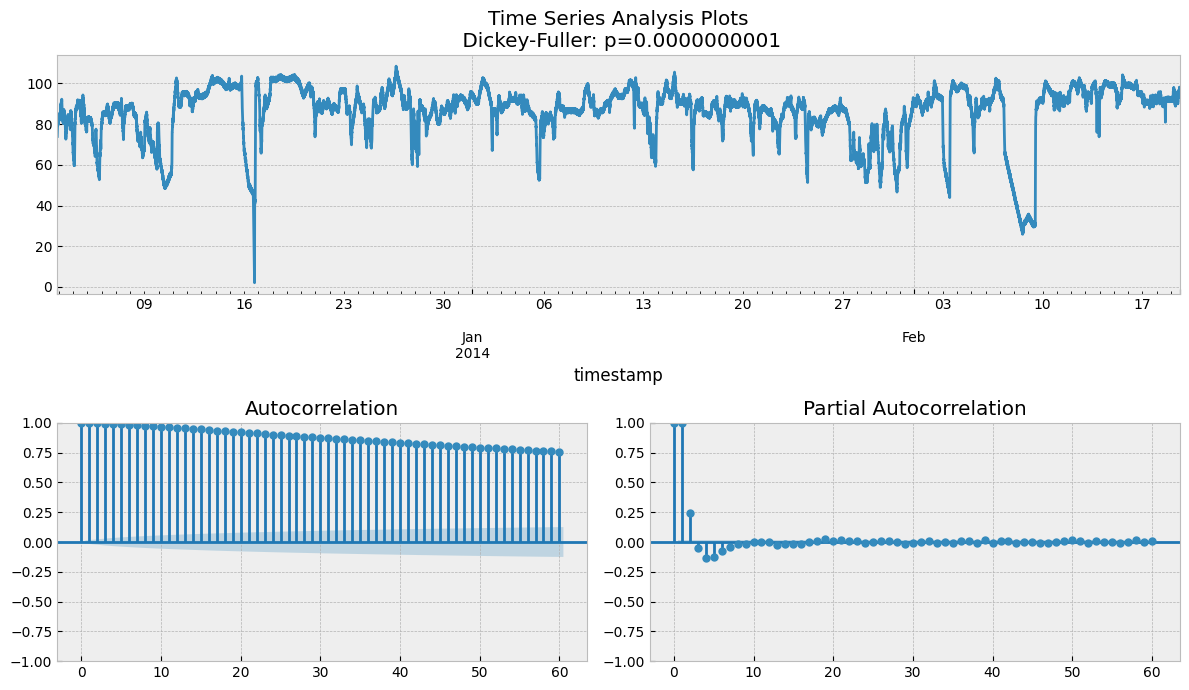

In [30]:
tsplot(nab.value, lags=60)

## Проверьте стационарность полученного ряда с тестом Дики-Фуллера и визуализацией ACF/PACF

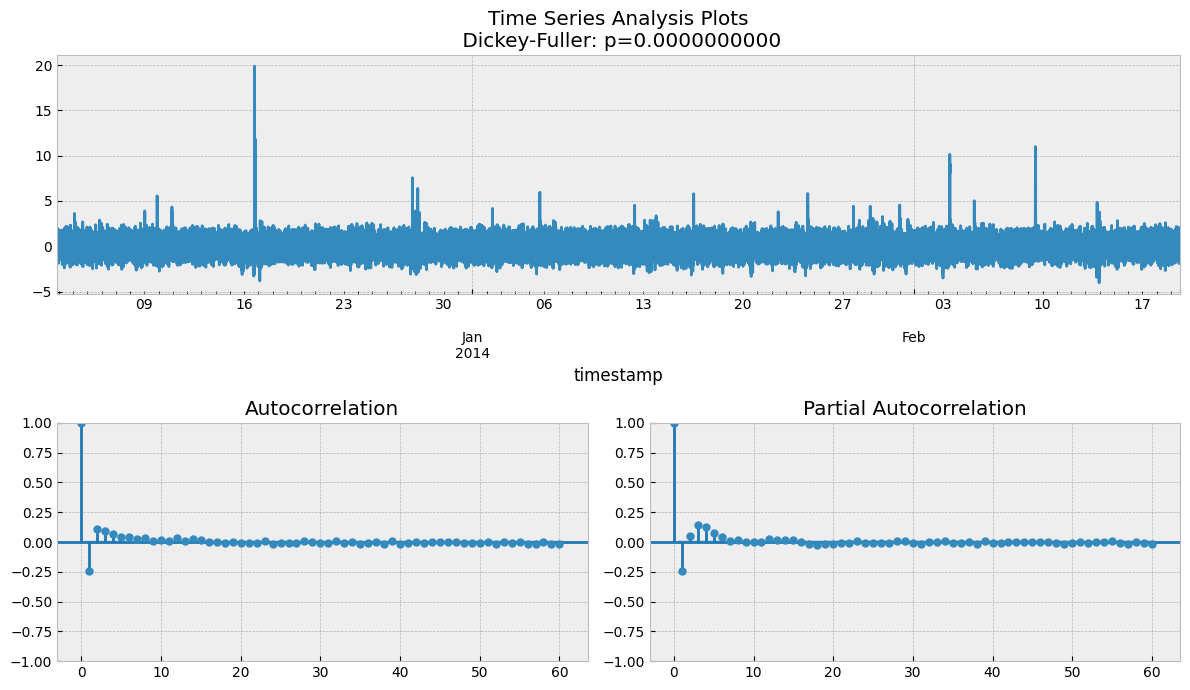

In [31]:
nab_diff = nab.value.diff().dropna()
tsplot(nab_diff, lags=60)

## Обучите модель ARIMA или SARIMA для прогнозирования значений ряда, подобрав оптимальные параметры

In [32]:
# setting initial values and some bounds for them
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
s = 12  # corresponding to a daily cycle for data every 5 minutes

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [33]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(nab.value, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

In [34]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 11min 23s, sys: 24.9 s, total: 11min 48s
Wall time: 9min 16s


## Визуализируйте результаты работы модели, произведите замеры качества модели ARIMA (или SARIMA)

In [35]:
result_table.head()

parameters           aic
0  (1, 1, 1, 1)  66301.058628
1  (1, 0, 1, 1)  66322.174515
2  (1, 1, 0, 1)  66332.614436
3  (1, 0, 0, 1)  66355.933715
4  (0, 1, 1, 1)  66567.795230

In [36]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(nab.value, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                22683
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -33145.529
Date:                            Tue, 05 Nov 2024   AIC                          66301.059
Time:                                    08:34:29   BIC                          66341.203
Sample:                                12-02-2013   HQIC                         66314.113
                                     - 02-19-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3341      0.018    -18.107      0.000      -0.370      -0.298
ma.L1          0.0917      0.016   

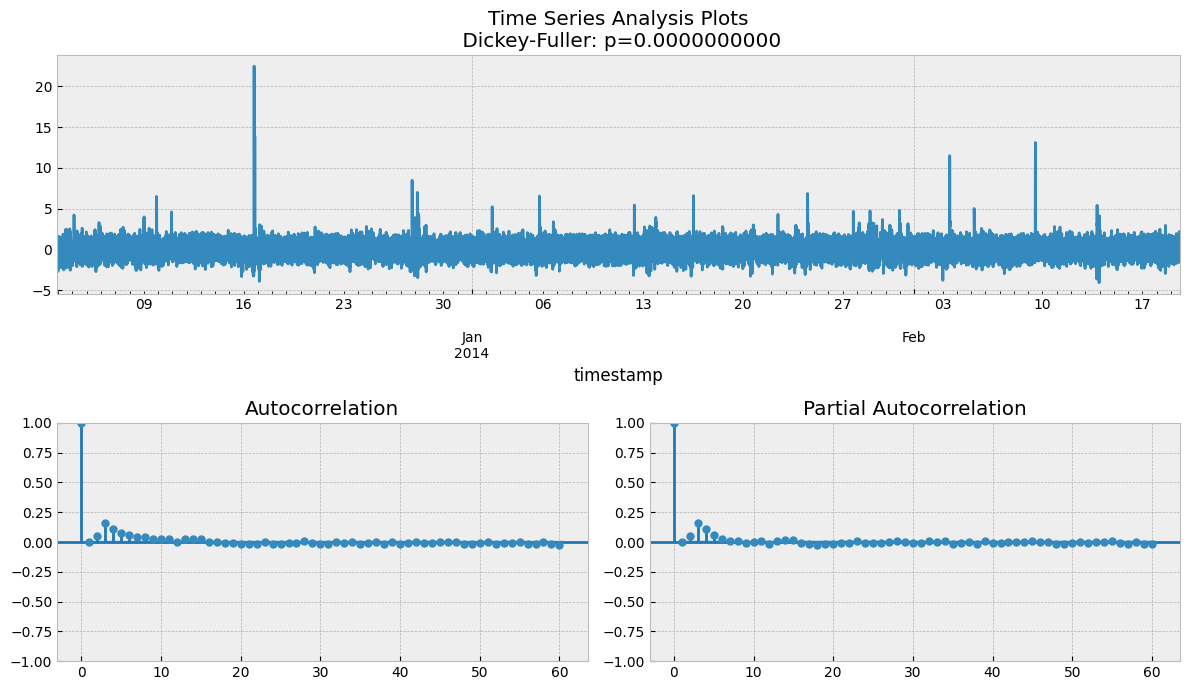

In [37]:
tsplot(best_model.resid[12+1:], lags=60)

In [38]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values

        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future

    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN

    # forecasting on n_steps forward
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model._append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

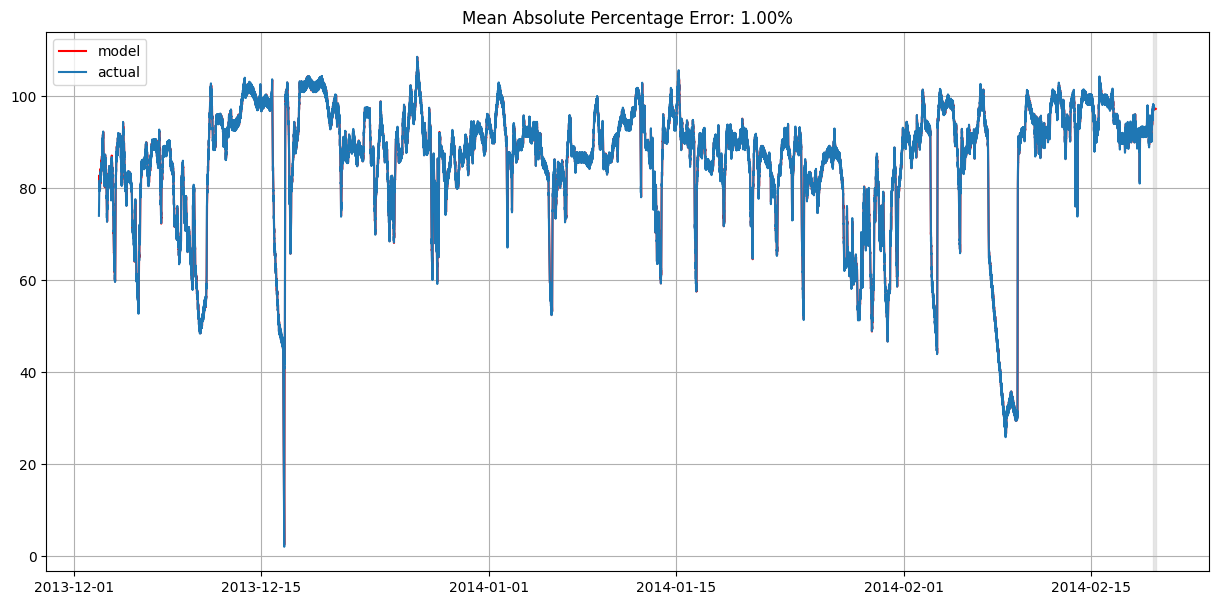

In [39]:
plotSARIMA(nab, best_model, 50)

# Классическая модель

## Используйте Feature-Engineering для создания признаков (лаги, скользящие статистики, признаки даты/времени, etc)

In [40]:
# Creating a copy of the initial datagrame to make various transformations
data = pd.DataFrame(nab.value.copy())
data.columns = ["y"]

In [41]:
# Adding the lag of the target variable from 72 steps back up to 300
for i in range(72, 300):
    data["lag_{}".format(i)] = data.y.shift(i)

In [42]:
# take a look at the new dataframe
data.tail(7)

y     lag_72     lag_73     lag_74     lag_75  \
timestamp                                                                    
2014-02-19 14:55:00  98.162952  94.749277  94.093054  92.957298  93.596673   
2014-02-19 15:00:00  97.360905  94.538068  94.749277  94.093054  92.957298   
2014-02-19 15:05:00  98.185415  94.654498  94.538068  94.749277  94.093054   
2014-02-19 15:10:00  97.804168  93.606260  94.654498  94.538068  94.749277   
2014-02-19 15:15:00  97.135468  95.792435  93.606260  94.654498  94.538068   
2014-02-19 15:20:00  98.056852  95.234234  95.792435  93.606260  94.654498   
2014-02-19 15:25:00  96.903861  95.675717  95.234234  95.792435  93.606260   

                        lag_76     lag_77     lag_78     lag_79     lag_80  \
timestamp                                                                    
2014-02-19 14:55:00  93.434590  91.789657  92.437184  92.487267  90.713920   
2014-02-19 15:00:00  93.596673  93.434590  91.789657  92.437184  92.487267   
2014-02-19 15:05:00  92.957298  93.596673  93.434590  91.789657  92.437184   
2014-02-19 15:10:00  94.093054  92.957298  93.596673  93.434590  91.789657   
2014-02-19 15:15:00  94.749277  94.093054  92.957298  93.596673  93.434590   
2014-02-19 15:20:00  94.538068  94.749277  94.093054  92.957298  93.596673   
2014-02-19 15:25:00  94.654498  94.538068  94.749277  94.093054  92.957298   

                     ...    lag_290    lag_291    lag_292    lag_293  \
timestamp            ...                                               
2014-02-19 14:55:00  ...  82.953906  83.731850  86.411116  87.761222   
2014-02-19 15:00:00  ...  80.969539  82.953906  83.731850  86.411116   
2014-02-19 15:05:00  ...  82.222039  80.969539  82.953906  83.731850   
2014-02-19 15:10:00  ...  84.827809  82.222039  80.969539  82.953906   
2014-02-19 15:15:00  ...  86.682046  84.827809  82.222039  80.969539   
2014-02-19 15:20:00  ...  87.361085  86.682046  84.827809  82.222039   
2014-02-19 15:25:00  ...  88.669394  87.361085  86.682046  84.827809   

                       lag_294    lag_295    lag_296    lag_297    lag_298  \
timestamp                                                                    
2014-02-19 14:55:00  88.897385  88.874511  87.836487  89.286875  89.351600   
2014-02-19 15:00:00  87.761222  88.897385  88.874511  87.836487  89.286875   
2014-02-19 15:05:00  86.411116  87.761222  88.897385  88.874511  87.836487   
2014-02-19 15:10:00  83.731850  86.411116  87.761222  88.897385  88.874511   
2014-02-19 15:15:00  82.953906  83.731850  86.411116  87.761222  88.897385   
2014-02-19 15:20:00  80.969539  82.953906  83.731850  86.411116  87.761222   
2014-02-19 15:25:00  82.222039  80.969539  82.953906  83.731850  86.411116   

                       lag_299  
timestamp                       
2014-02-19 14:55:00  89.221664  
2014-02-19 15:00:00  89.351600  
2014-02-19 15:05:00  89.286875  
2014-02-19 15:10:00  87.836487  
2014-02-19 15:15:00  88.874511  
2014-02-19 15:20:00  88.897385  
2014-02-19 15:25:00  87.761222  

[7 rows x 229 columns]

In [43]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

tscv = TimeSeriesSplit(n_splits=5)

In [44]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [45]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [46]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [47]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [48]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies

    """

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train,
                                    cv=tscv,
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=3, label = "Anomalies")

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

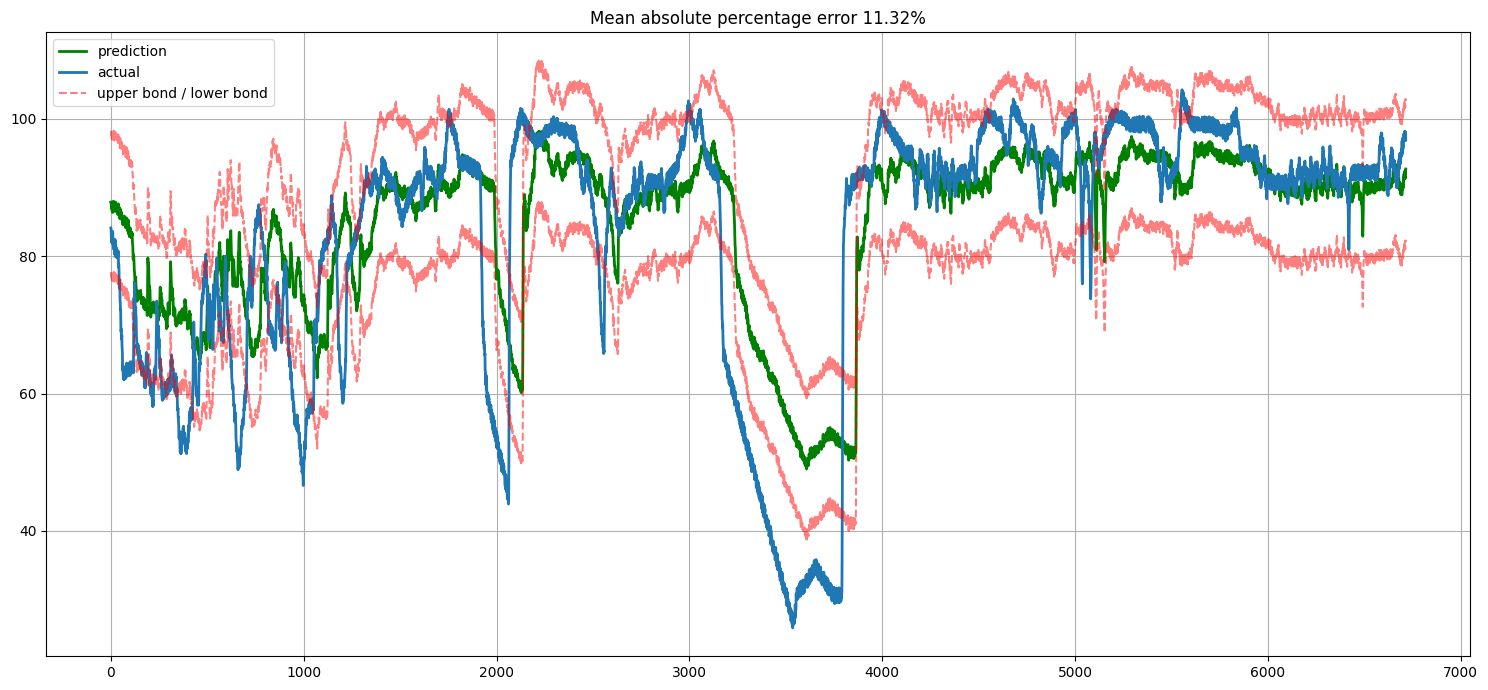

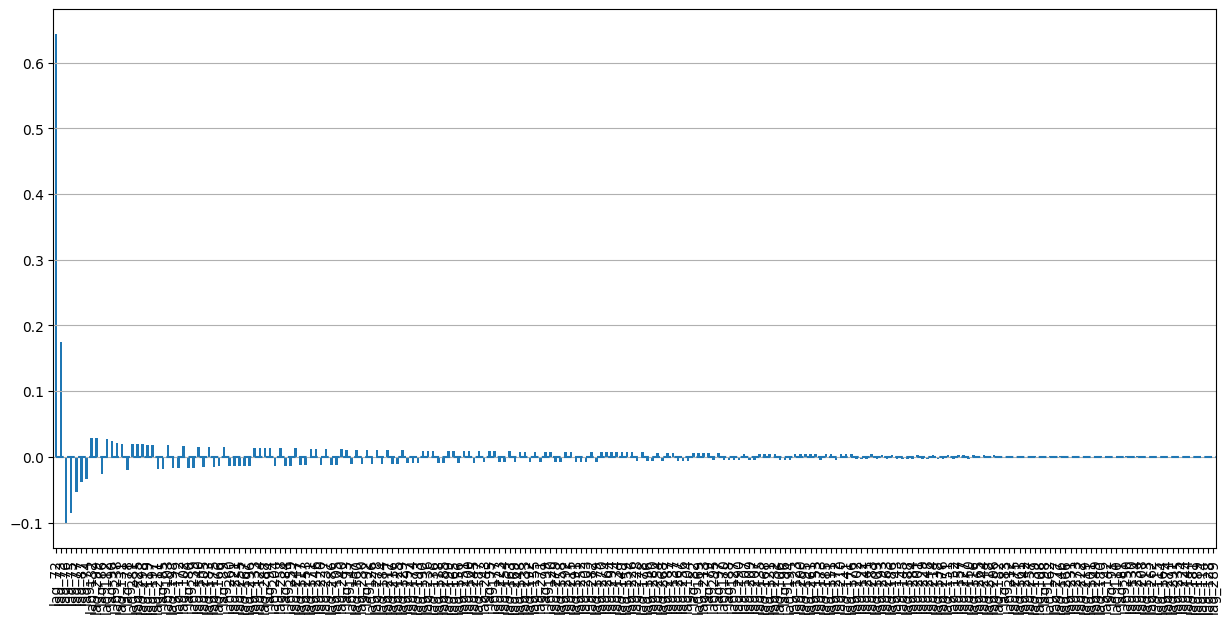

In [49]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [50]:
data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5, 6]) * 1
data.tail()

y     lag_72     lag_73     lag_74     lag_75  \
timestamp                                                                    
2014-02-19 15:05:00  98.185415  94.654498  94.538068  94.749277  94.093054   
2014-02-19 15:10:00  97.804168  93.606260  94.654498  94.538068  94.749277   
2014-02-19 15:15:00  97.135468  95.792435  93.606260  94.654498  94.538068   
2014-02-19 15:20:00  98.056852  95.234234  95.792435  93.606260  94.654498   
2014-02-19 15:25:00  96.903861  95.675717  95.234234  95.792435  93.606260   

                        lag_76     lag_77     lag_78     lag_79     lag_80  \
timestamp                                                                    
2014-02-19 15:05:00  92.957298  93.596673  93.434590  91.789657  92.437184   
2014-02-19 15:10:00  94.093054  92.957298  93.596673  93.434590  91.789657   
2014-02-19 15:15:00  94.749277  94.093054  92.957298  93.596673  93.434590   
2014-02-19 15:20:00  94.538068  94.749277  94.093054  92.957298  93.596673   
2014-02-19 15:25:00  94.654498  94.538068  94.749277  94.093054  92.957298   

                     ...    lag_293    lag_294    lag_295    lag_296  \
timestamp            ...                                               
2014-02-19 15:05:00  ...  83.731850  86.411116  87.761222  88.897385   
2014-02-19 15:10:00  ...  82.953906  83.731850  86.411116  87.761222   
2014-02-19 15:15:00  ...  80.969539  82.953906  83.731850  86.411116   
2014-02-19 15:20:00  ...  82.222039  80.969539  82.953906  83.731850   
2014-02-19 15:25:00  ...  84.827809  82.222039  80.969539  82.953906   

                       lag_297    lag_298    lag_299  hour  weekday  \
timestamp                                                             
2014-02-19 15:05:00  88.874511  87.836487  89.286875    15        2   
2014-02-19 15:10:00  88.897385  88.874511  87.836487    15        2   
2014-02-19 15:15:00  87.761222  88.897385  88.874511    15        2   
2014-02-19 15:20:00  86.411116  87.761222  88.897385    15        2   
2014-02-19 15:25:00  83.731850  86.411116  87.761222    15        2   

                     is_weekend  
timestamp                        
2014-02-19 15:05:00           0  
2014-02-19 15:10:00           0  
2014-02-19 15:15:00           0  
2014-02-19 15:20:00           0  
2014-02-19 15:25:00           0  

[5 rows x 232 columns]

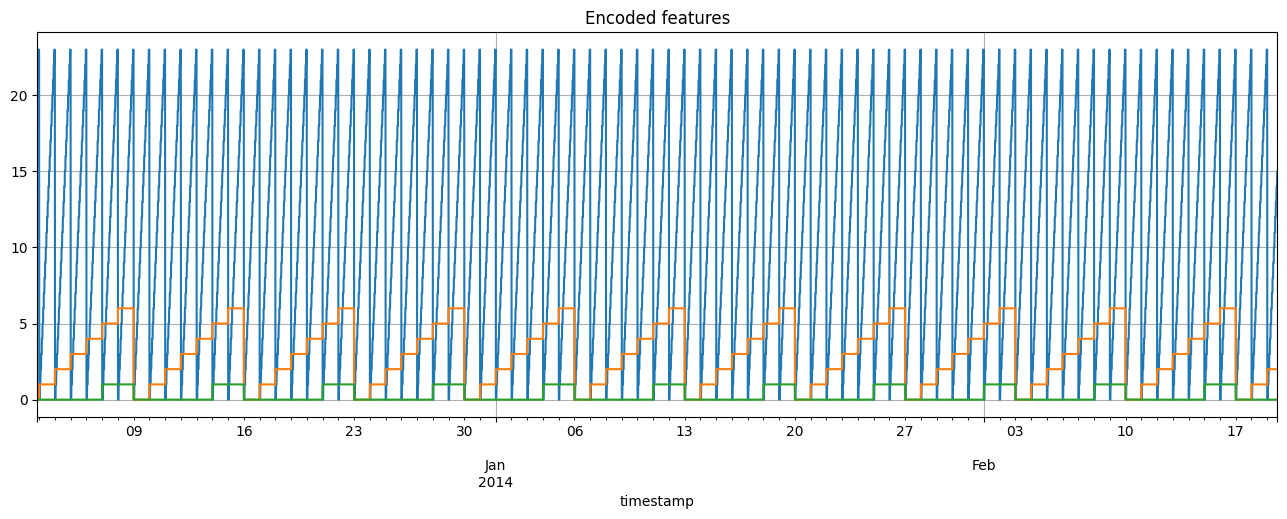

In [51]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

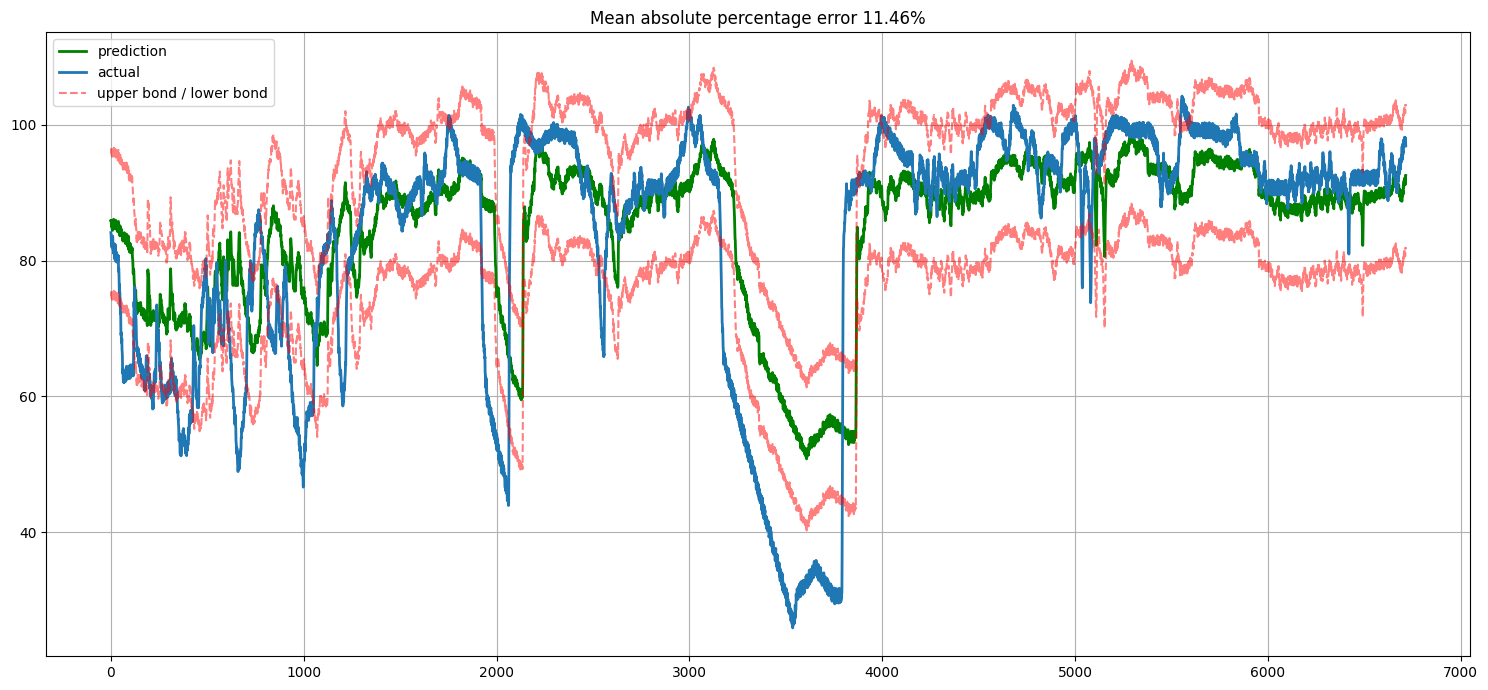

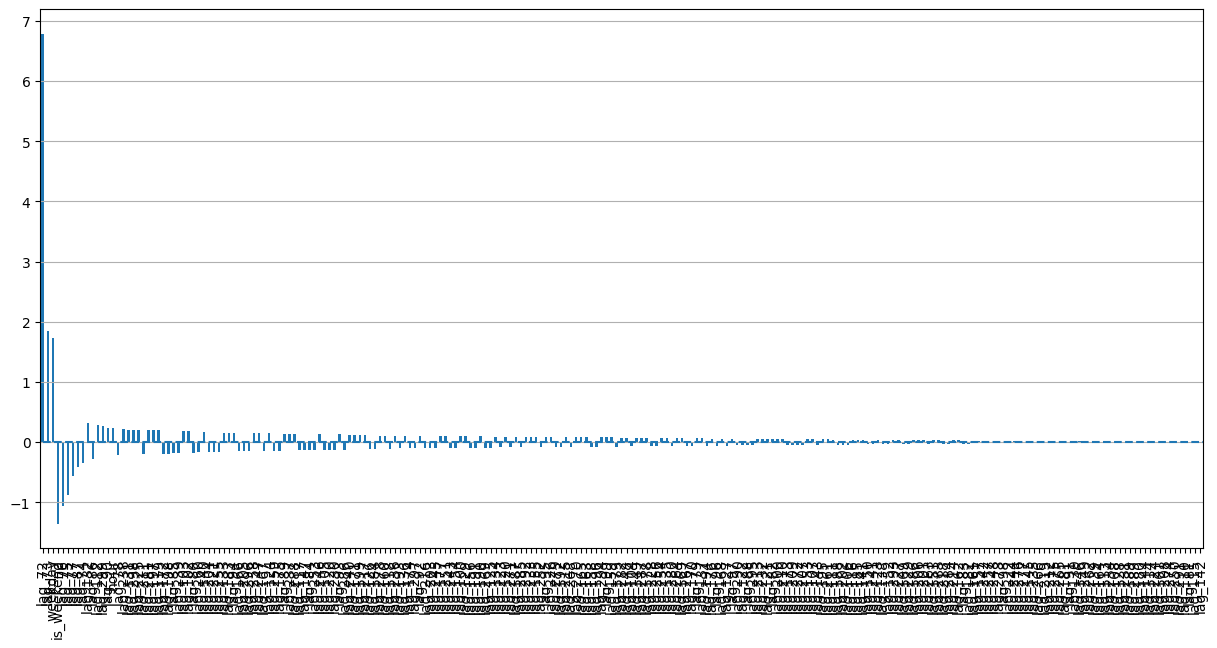

In [53]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

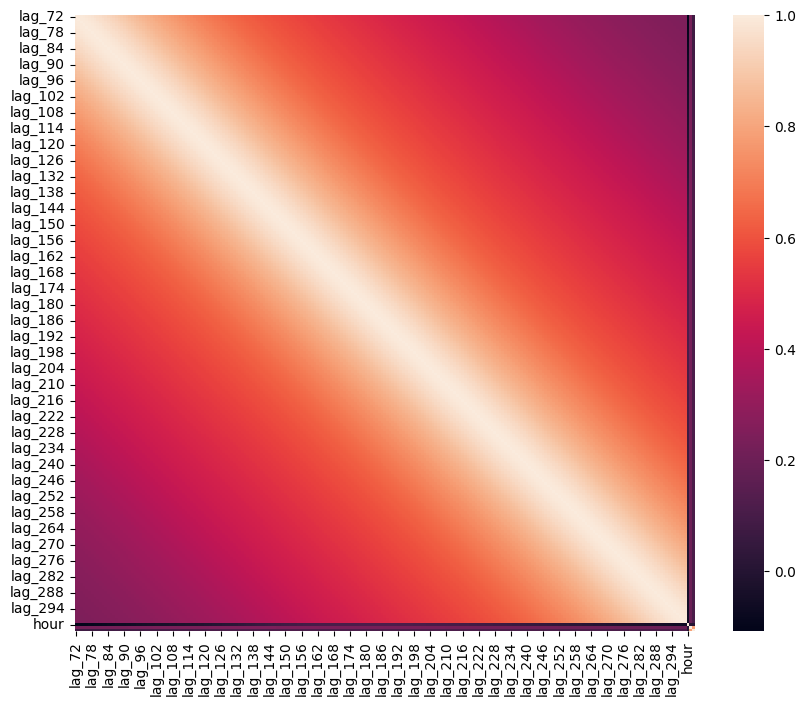

In [54]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

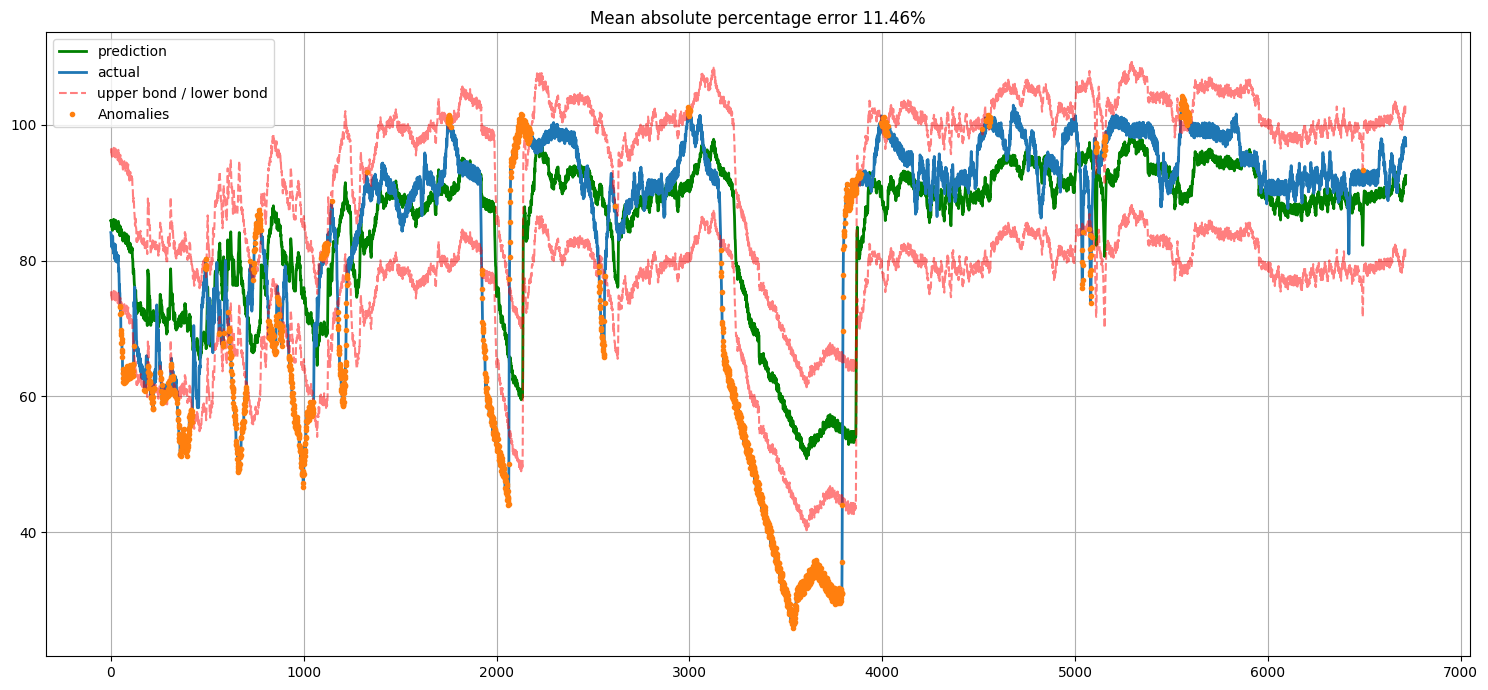

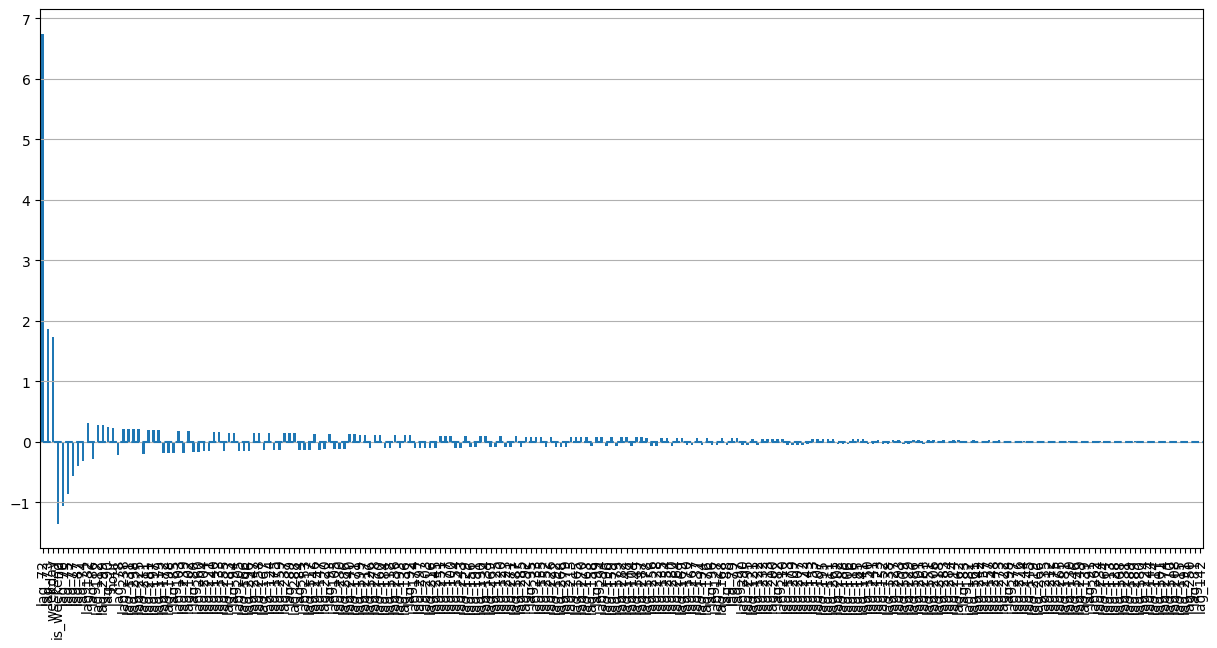

In [55]:
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge

ridge = RidgeCV(cv=tscv, alphas=np.linspace(0.1, 1, 10))
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge,
                 X_train=X_train_scaled,
                 X_test=X_test_scaled,
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

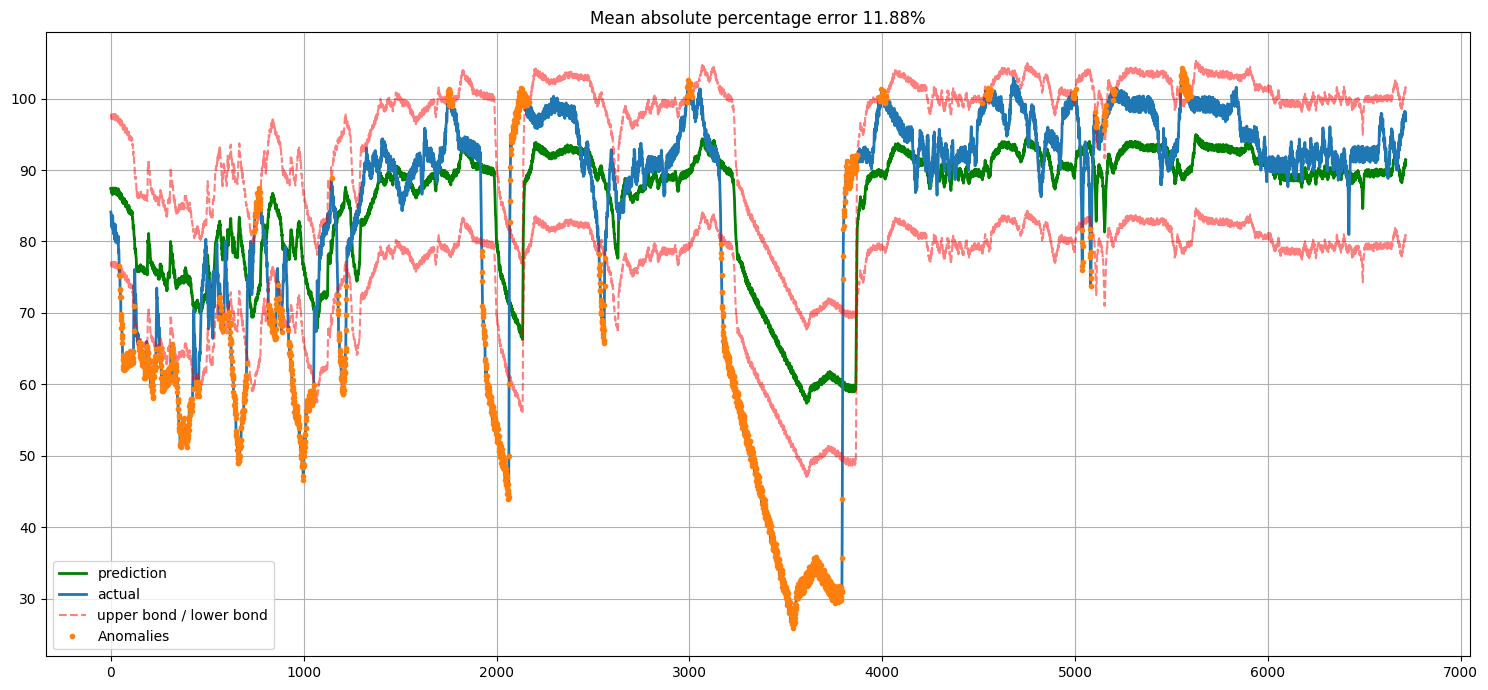

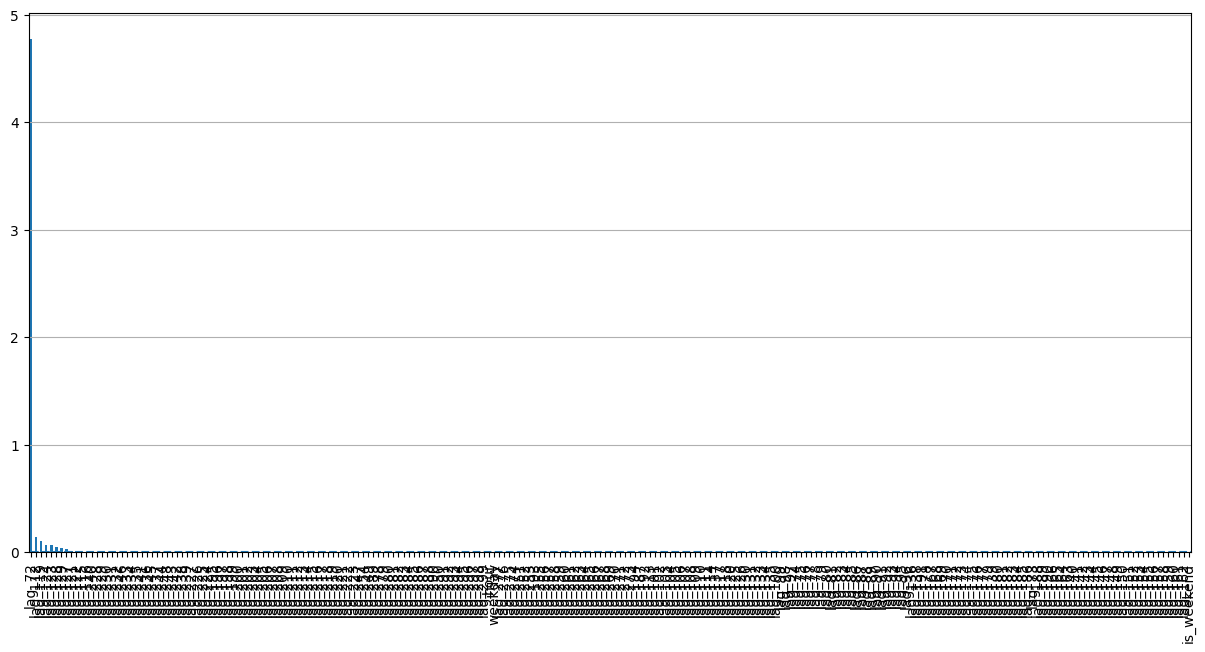

In [56]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso,
                 X_train=X_train_scaled,
                 X_test=X_test_scaled,
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

## На полученном наборе данных обучите случайный лес или градиентный бустинг

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)

plotModelResults(rf, X_train=X_train, X_test=X_test, plot_intervals=True, plot_anomalies=True)

In [111]:
from sklearn.model_selection import GridSearchCV

In [112]:
%%time

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [7, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
gs = GridSearchCV(rf, param_grid, cv=tscv, n_jobs=-1)
gs.fit(X_train, y_train)

PicklingError: Could not pickle the task to send it to the workers.

## Визуализируйте результаты работы модели, произведите замеры качества модели

In [113]:
plotModelResults(gs.best_estimator_, X_train=X_train, X_test=X_test, plot_intervals=True, plot_anomalies=True)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

# Нейросетевая модель

## Обучить на выбранном временном ряду модель RNNModel из библиотеки ETNA

In [57]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

In [58]:
scaler = MinMaxScaler(feature_range=(0, 1))
nab_resampled['value'] = scaler.fit_transform(nab_resampled[['value']])

In [59]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

In [60]:
sequence_length = 24  # 24 steps (2 h)
X, y = create_sequences(nab_resampled['value'].values, sequence_length)

In [61]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [62]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])

In [63]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0315 - val_loss: 1.4025e-04
Epoch 2/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 1.5552e-04 - val_loss: 1.6093e-04
Epoch 3/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 1.4831e-04 - val_loss: 1.2360e-04
Epoch 4/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 1.1961e-04 - val_loss: 1.1574e-04
Epoch 5/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 1.0891e-04 - val_loss: 2.0240e-04
Epoch 6/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 1.2099e-04 - val_loss: 1.1309e-04
Epoch 7/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 1.1645e-04 - val_loss: 1.3557e-04
Epoch 8/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 1.1623e-04 - val_loss: 8.4118e-05
Epoch 9/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 1.1218e-04 - val_loss: 9.8864e-05
Epoch 10/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 1.2925e-04 - val_loss: 1.4866e-04
Epoch 11/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 9s 16m

In [64]:
predictions = model.predict(X_test)

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [65]:
predicted_values = scaler.inverse_transform(predictions)
true_values = scaler.inverse_transform(y_test.reshape(-1, 1))

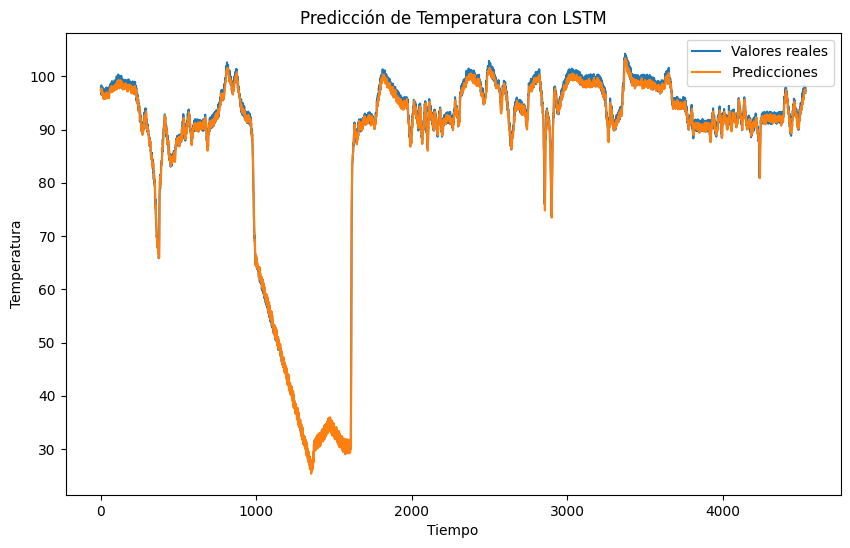

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(true_values, label='Valores reales')
plt.plot(predicted_values, label='Predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Temperatura')
plt.title('Predicción de Temperatura con LSTM')
plt.legend()
plt.show()

## Обучить на выбранном временном ряду модель DeepAR с Feaure-Engineering из библиотеки ETNA

In [81]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [1]:
pip install -U git+https://github.com/awslabs/gluonts.git

  Cloning https://github.com/awslabs/gluonts.git to /tmp/pip-req-build-j_g5limo
  Running command git clone --filter=blob:none --quiet https://github.com/awslabs/gluonts.git /tmp/pip-req-build-j_g5limo
  Resolved https://github.com/awslabs/gluonts.git to commit 3d05d465f97096583d87a6827948e0d0d3cb7e92
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

ModuleNotFoundError: No module named 'gluonts.model.deepar'

In [69]:
prediction_length = 24
freq = "5min"

In [70]:
train_ds = ListDataset(
    [{"start": nab_resampled.index[0], "target": nab_resampled['value'][:-prediction_length]}],
    freq=freq
)

NameError: name 'ListDataset' is not defined

In [ ]:
estimator = DeepAREstimator(
    freq=freq,
    prediction_length=prediction_length,
    trainer=Trainer(epochs=10, ctx=mx.cpu())
)

In [ ]:
predictor = estimator.train(train_ds)

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds, predictor=predictor, num_samples=100
)

forecasts = list(forecast_it)
tss = list(ts_it)

In [ ]:
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts))

In [ ]:
print(f"Evaluation metrics: {agg_metrics}")

# Graficar los resultados
for target, forecast in zip(tss, forecasts):
    target.plot()
    forecast.plot()
    plt.legend(["Real values", "Forecast"])
    plt.show()